# Описание данных

Каждая запись в логе — это действие пользователя, или событие
 - EventName — название события;
 - DeviceIDHash — уникальный идентификатор пользователя;
 - EventTimestamp — время события;
 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Обзор и предобработка данных

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
import os
import plotly
import plotly.graph_objs as go
from scipy import stats as st
import math as mth

In [3]:
try:
    logs = pd.read_csv('/datasets/data.csv', sep='\t')
except:
    logs = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv', sep='\t')

In [3]:
# функция для обзора данных

def observe_data(data):
    print("\033[1m\033[34m {}".format('Первые 10 строк датасета:'))
    display(data.head(10))
    print("\033[1m\033[34m {}".format('Числовое описание данных:'))
    display(data.describe())
    print("\033[1m\033[34m {}".format('Общая информация о датасете:'))
    print("\033[0m {}".format(''))
    data.info()
    print()
    print("\033[1m\033[34m {}".format('Пропуски в данных:'))
    display(data.isna().sum())
    print("\033[1m\033[34m {}".format('Дубликаты:'))
    display(data.duplicated().sum())

In [4]:
observe_data(logs)

 Первые 10 строк датасета:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


 Числовое описание данных:


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


 Общая информация о датасете:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

 Пропуски в данных:


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

 Дубликаты:


413

In [5]:
# удаляем дубликаты

logs = logs.drop_duplicates().reset_index(drop=True)
logs.duplicated().sum()

0

In [6]:
# меняем названия столбцов на более удобные
logs.columns = ['event_name', 'user_id', 'event_ts', 'exp_id']

# добавляем столбец с датой
logs['event_ts'] = pd.to_datetime(logs['event_ts'], unit='s') 
logs['date'] = logs['event_ts'].astype('datetime64[D]')
logs['date'] = logs['date'].dt.floor('1D')

logs.head()

,event_name,user_id,event_ts,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


**Вывод:**
 - Пропусков в данных нет
 - Удалили 413 дубликатов
 - Поменяли названия столбцов на более удобные в snake_case
 - Изменили тип столбца с датой на datetime
 - Добавили новый столбец только с датой date

# Исследовательский анализ данных

## Сколько всего событий в логе?

In [7]:
logs['event_name'].count()

243713

In [8]:
print(logs['event_name'].value_counts())
print()
print(
    'MainScreenAppear =',
    round(logs[logs['event_name'] == 'MainScreenAppear']['event_name'].count()/logs['event_name'].count()*100, 2),
    '%')

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

MainScreenAppear = 48.87 %


 - Всего событий в логе - 243713
 - Уникальных событий - 5:
   - (увидел) главный экран
   - (увидел) предложения
   - (увидел) корзина
   - успешная оплата (успешно оплатил)
   - (увидел) руководство
 - Самое большое количество событий приходится на "главный экран" - 119101, это 48.8% от всех событий

## Сколько всего пользователей в логе?

In [9]:
logs['user_id'].nunique()

7551

 - Число уникальных пользователей - 7551

## Сколько в среднем событий приходится на пользователя?

In [10]:
round(logs['event_name'].count()/logs['user_id'].nunique(), 2)

32.28

 - В среднем на одного пользователя приходится 32 события

## Распределение данных по времени

In [11]:
# минимальная и максимальная дата в логах

print(logs['event_ts'].min())
print(logs['event_ts'].max())
logs['event_ts'].max() - logs['event_ts'].min()

2019-07-25 04:43:36
2019-08-07 21:15:17


Timedelta('13 days 16:31:41')

 - Мы располагаем данными с 25 июля 2019 года по 7 августа 2019 года
 - Получается 13 дней и 16 часов (почти две недели)

In [12]:
# считаем, сколько событий было каждый день в разрезе по группам

event_d = logs.pivot_table(index='date', values='event_name', columns='exp_id', aggfunc='count')
event_d

exp_id,246,247,248
date,,,
2019-07-25,4,1,4
2019-07-26,14,8,9
2019-07-27,24,23,8
2019-07-28,33,36,36
2019-07-29,55,58,71
2019-07-30,129,138,145
2019-07-31,620,664,746
2019-08-01,11561,12306,12274
2019-08-02,10946,10990,13618


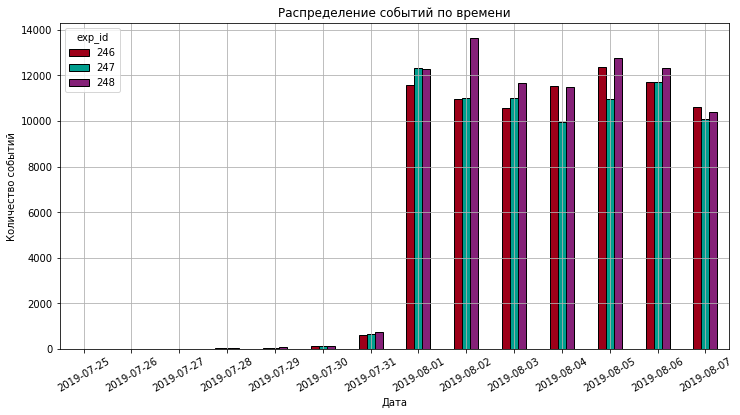

In [13]:
# строим график распределения событий по времени в разрезе групп

fix, ax = plt.subplots(figsize=(12,6))
fig = event_d.plot(kind='bar', grid=True, edgecolor='black', color={'#9D0019', '#009E8E', '#852178'}, ax=ax)
ax.set_xticklabels(labels=pd.Series(event_d.index).dt.strftime("%Y-%m-%d").sort_values())
plt.title('Распределение событий по времени')
plt.xlabel('Значение')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=30)
plt.grid(True)

 - На графике видно, что на рубеже первой и второй недели количество событий резко выросло
 - Либо до 1 августа не было такой активности, либо данные за этот период неполные
 - Отфильтруем полные данные и отбросим старые

In [14]:
new_logs = logs.loc[logs['date'] > '2019-07-31']
new_logs.head()

,event_name,user_id,event_ts,exp_id,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [15]:
# проверим количество событий и пользователей после фильтрации

print('Количество потерянных пользователей:', logs['user_id'].nunique()-new_logs['user_id'].nunique())
print('Процент потерянных пользователей:', round(100-new_logs['user_id'].nunique()/logs['user_id'].nunique()*100, 2))
print('Количество потерянных событий:', logs['event_name'].count()-new_logs['event_name'].count())
print('Процент потерянных событий:', round(100-new_logs['event_name'].count()/logs['event_name'].count()*100, 2))

Количество потерянных пользователей: 17
Процент потерянных пользователей: 0.23
Количество потерянных событий: 2826
Процент потерянных событий: 1.16


 - Итого потерянных пользователей менее 1%
 - Потерянных событий чуть более 1%
 - Это незначительные показатели, такие потери критично на результаты исследования не повлияют

In [16]:
# проверим экспериментальные группы

display(new_logs.groupby('exp_id')['user_id'].nunique())
new_logs.groupby('exp_id')['event_name'].count()

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

exp_id
246    79302
247    77022
248    84563
Name: event_name, dtype: int64

## Вывод

 - Всего событий в логе - 243713
 - Уникальных событий - 5:
   - (увидел) главный экран
   - (увидел) предложения
   - (увидел) корзина
   - успешная оплата (успешно оплатил)
   - (увидел) руководство
 - Самое большое количество событий приходится на "главный экран" - 48.8% от всех событий
 - Число уникальных пользователей - 7551
 - В среднем на одного пользователя приходится 32 события
 - После фильтрации мы располагаем данными с 1 по 7 августа 2019 года
 - Имеется 3 экспериментальные группы примерно с одинаковым количеством пользователей и событий в каждой

# Воронка событий

In [17]:
# события и их количество
new_logs['event_name'].value_counts().reset_index()

,index,event_name
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [18]:
# уникальные пользователи на каждое событие

event_users = new_logs.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
event_users

,event_name,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [19]:
# процент пользователей от общего числа пользователей по каждому событию

event_users['percent'] = (event_users['user_id']/new_logs['user_id'].nunique()*100).round(2)
event_users

,event_name,user_id,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Предположительно воронка событий выглядит так:
 - главный экран
   - предложения
      - корзина
        - успешная оплата (успешно оплатил)

Пункт "руководство" не входит в эту воронку, поскольку необязателен для покупки товара

In [20]:
# уберем пункт "tutorial", т.к. он не входит в воронку событий

event_users = event_users.drop([4], axis=0)
event_users

,event_name,user_id,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


In [21]:
# посчитаем конверсию пользователей на следующий шаг

event_users['conversion_%'] = 100
for i in range(1, 4):
    event_users.loc[i, 'conversion_%'] = ((event_users.loc[i, 'user_id'] / (event_users.loc[i-1, 'user_id']))*100).round(2)

event_users

,event_name,user_id,percent,conversion_%
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


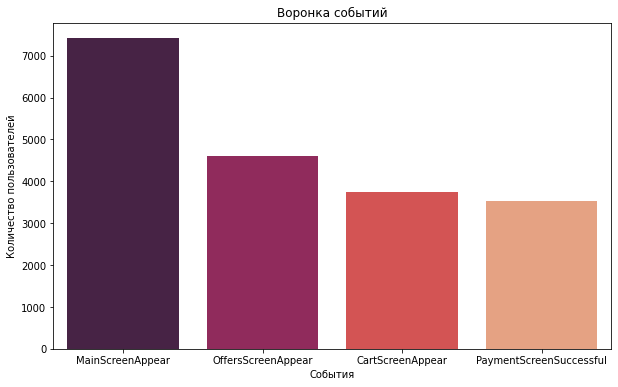

In [22]:
# представим воронку визуально

plt.figure(figsize=(10, 6))
sns.barplot(data=event_users, x='event_name', y='user_id', palette='rocket')
sns.set_theme(style='darkgrid')
plt.title('Воронка событий')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.show();

In [23]:
# доля покупателей от всех пользователей

(event_users.loc[3, 'user_id']/event_users.loc[0, 'user_id'])*100

47.70184661005526

**Вывод:**

Воронка событий:
   - главный экран
      - предложения (конв. 61.91%)
         - корзина (конв. 81.30%)
            - успешная оплата (успешно оплатил) (конв. 94.78%)

Посчитана конверсия каждого события в следующее событие:
  - больше всего пользователей теряются на втором шаге "предложения"/"OffersScreenAppear" - почти 40%
  - далее при переходе в "корзину" теряется около 20% пользователей
  - далее - почти 15% пользователей при переходе к оплате

Таким образом, с первого события "MainScreenAppear"/"главный экран" до покупки товара доходит чуть более 47% пользователей 

# Анализ А/А/В-теста

In [24]:
# количество пользователей в экспериментальных группах
display(new_logs.groupby('exp_id')['user_id'].nunique())

# проверим, все ли пользователи уникальны в каждой из групп
len(new_logs.groupby('user_id')['exp_id'].nunique().reset_index().query('exp_id > 1'))

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

0

 - В группах А получается по 2484 и 2513 пользователей
 - В группе В - 2537 пользователей
 - Среди пользователей нет тех, кто попал в несколько групп

In [25]:
# сделаем сводную таблицу с количеством пользователей по событиям

event_group = new_logs.pivot_table(index='event_name',
                                   columns='exp_id',
                                   values='user_id',
                                   aggfunc='nunique',
                                   margins=True).reset_index().sort_values('All',
                                                                           ascending=False).reset_index(drop=True)
event_group = event_group.reindex([1, 2, 3, 4, 5, 0]).reset_index(drop=True)
event_group

exp_id,event_name,246,247,248,All
0,MainScreenAppear,2450,2476,2493,7419
1,OffersScreenAppear,1542,1520,1531,4593
2,CartScreenAppear,1266,1238,1230,3734
3,PaymentScreenSuccessful,1200,1158,1181,3539
4,Tutorial,278,283,279,840
5,All,2484,2513,2537,7534


In [26]:
print('Количество пользователей в группах различается на',
      round(100 - (event_group.loc[5,246] / event_group.loc[5,247] * 100), 2),
      '%')

Количество пользователей в группах различается на 1.15 %


 - Количество пользователей в группах А (246 и 247) различается на 1.15%, это почти норма, немного больше, чем 1%
 - Посчитаем эту разницу приемлемой

Сформулируем гипотезы для проверки статистических показателей:
 - Н0: между количеством пользователей при этом событии нет статистически значимой разницы 
 - Н1: между количеством пользователей при этом событии есть статистически значимая разница

In [27]:
# функция для проверки различий

def check_difference(successes1, successes2, trials1, trials2):
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    # пропорция успехов во второй группе:
    p2 = successes2/trials2
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / (p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) ** 0.5
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    alpha = 0.003125
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

**Проверим гипотезу на группах 246 (А) и 247 (А) на каждом шаге:**

In [28]:
check_difference(event_group.loc[1, 246], event_group.loc[1, 247], event_group.loc[0, 246], event_group.loc[0, 247])

p-значение:  0.2622344959255778
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [29]:
check_difference(event_group.loc[2, 246], event_group.loc[2, 247], event_group.loc[1, 246], event_group.loc[1, 247])

p-значение:  0.6393754713145263
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [30]:
check_difference(event_group.loc[3, 246], event_group.loc[3, 247], event_group.loc[2, 246], event_group.loc[2, 247])

p-значение:  0.18243439408067652
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [31]:
check_difference(event_group.loc[3, 246], event_group.loc[3, 247], event_group.loc[5, 246], event_group.loc[5, 247])

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


 - Нет оснований отвергать нулевую гипотезу, значит между группами 246 (А) и 247 (А) нет статистически значимых различий

**Проверим гипотезу на группах 246 (А) и 248 (В):**

In [32]:
check_difference(event_group.loc[1, 246], event_group.loc[1, 248], event_group.loc[0, 246], event_group.loc[0, 248])

p-значение:  0.2684281587249231
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [33]:
check_difference(event_group.loc[2, 246], event_group.loc[2, 248], event_group.loc[1, 246], event_group.loc[1, 248])

p-значение:  0.2112170818054686
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [34]:
check_difference(event_group.loc[3, 246], event_group.loc[3, 248], event_group.loc[2, 246], event_group.loc[2, 248])

p-значение:  0.14295341270419004
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [35]:
check_difference(event_group.loc[3, 246], event_group.loc[3, 248], event_group.loc[5, 246], event_group.loc[5, 248])

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


 - Нет оснований отвергать нулевую гипотезу, значит между группами 246 (А) и 248 (В) нет статистически значимых различий

**Проверим гипотезу на группах 247 (А) и 248 (В):**

In [36]:
check_difference(event_group.loc[1, 247], event_group.loc[1, 248], event_group.loc[0, 247], event_group.loc[0, 248])

p-значение:  0.9869365252844515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [37]:
check_difference(event_group.loc[2, 247], event_group.loc[2, 248], event_group.loc[1, 247], event_group.loc[1, 248])

p-значение:  0.4364903513062255
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [38]:
check_difference(event_group.loc[3, 247], event_group.loc[3, 248], event_group.loc[2, 247], event_group.loc[2, 248])

p-значение:  0.005677465395736325
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [39]:
check_difference(event_group.loc[3, 247], event_group.loc[3, 248], event_group.loc[5, 247], event_group.loc[5, 248])

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


 - Нет оснований отвергать нулевую гипотезу, значит между группами 247 (А) и 248 (В) нет статистически значимых различи на всех шагах, кроме последнего. Без поправки Бонферрони при переходе к шагу "PaymentScreenSuccessful" из шага "CartScreenAppear" в группах 247 и 248 есть статистически значимая разница. Но нет оснований отвергать нулевую гипотезу при сравнении количества пользователей между первым шагом и последним

**Проверим гипотезу на объединенных 246 (А) и 247 (А) группах и 248 (В):**

In [40]:
# объединим группы А (246 и 247)
event_group['246_n_247'] = event_group[246] + event_group[247]

In [41]:
check_difference(event_group.loc[1, '246_n_247'], event_group.loc[1, 248],
                 event_group.loc[0, '246_n_247'], event_group.loc[0, 248])

p-значение:  0.5308589432077624
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [42]:
check_difference(event_group.loc[2, '246_n_247'], event_group.loc[2, 248],
                 event_group.loc[1, '246_n_247'], event_group.loc[1, 248])

p-значение:  0.23905954279947372
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [43]:
check_difference(event_group.loc[3, '246_n_247'], event_group.loc[3, 248],
                 event_group.loc[2, '246_n_247'], event_group.loc[2, 248])

p-значение:  0.017114434319547067
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [44]:
check_difference(event_group.loc[3, '246_n_247'], event_group.loc[3, 248],
                 event_group.loc[5, '246_n_247'], event_group.loc[5, 248])

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


 - Нет оснований отвергать нулевую гипотезу, значит между объединенными 246 (А) и 247 (А) группами и 248 (В) нет статистически значимых различий

**Вывод:**
 - При выборе в качестве статистической значимости alpha=0.01, можем сделать вывод, что отвергнуть нулевую гипотезу не получилось
 - Значит статистически значимых различий между группами А нет
 - Статистически значимых различий между группами 246 и 248 также нету
 - Статистически значимых различий между группами 247 и 248 нету, кроме одного шага
 - Также нет различий между объединенными 246-247 группами и группой 248
 - Если взять уровень статистической значимости alpha=0.05, то также не получится отвергнуть нулевую гипотезу
 - Однако при переходе к шагу оплаты статистически значимая разница есть, а по общему количеству пользователей с первого до последнего шага статистически значимой разницы нет
 - **Если вносить поправку Бонферрони (разделим alpha=0.05 на 16), то alpha=0.003125, и тогда при проверке гипотез статистически значимой разницы между группами нет нигде**
 

# Вывод

1. **В ходе исследования были проанализированы данные мобильного приложения по продаже продуктов питания**


2. **Определена воронка событий:**
 - главный экран
   - предложения (конв. 61.91%)
     - корзина (конв. 81.30%)
       - успешная оплата (успешно оплатил) (конв. 94.78%)


3. **Посчитана конверсия каждого события в следующее событие:**
 - больше всего пользователей теряются на втором шаге "предложения"/"OffersScreenAppear" - почти 40%
 - далее при переходе в "корзину" теряется около 20% пользователей
 - далее - почти 15% пользователей при переходе к оплате
 - Таким образом, с первого события "MainScreenAppear"/"главный экран" до покупки товара доходит чуть более 47% пользователей


4. **Проведен анализ А/А/В-теста:**
 - статистически значимых различий между контрольными группами пользователей нет


5. Результат эксперимента: **между старым и новым шрифтом разницы нет**


6. **Рекомендуется проверить, почему после первого события в воронке - "MainScreenAppear"(просмотр главного экрана) - теряется 40% пользователей (больше всего по сравнению с другими шагами воронки)**